In [38]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

import re
from datetime import datetime

# OCR Methods 
import pytesseract
#import easyocr

# Image Preprocessing
import cv2

In [23]:
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# Outline
1. Take a look at the data
2. Extract text from images:
    - pytesseract
    - easyocr
3. Run on a few examples and compare the results
4. Once text is extracted, parse the results for the name and the expiration date

In [2]:
img_file_names = glob('Data\*')

In [3]:
img_file_names

['Data\\img1.png', 'Data\\img2.jpg']

# Plot Example Images

In [4]:
def display_imgs(img):
    fig, ax = plt.subplots(ncols = 2, figsize= (20,20))
    ax = ax.flatten()
    for i in range(len(img)):
        ax[i].imshow(plt.imread(img[i]))
        image_id = img[i].split('/')[-1].split('.')[0]
        ax[i].set_title(f'{image_id}')
    plt.show()

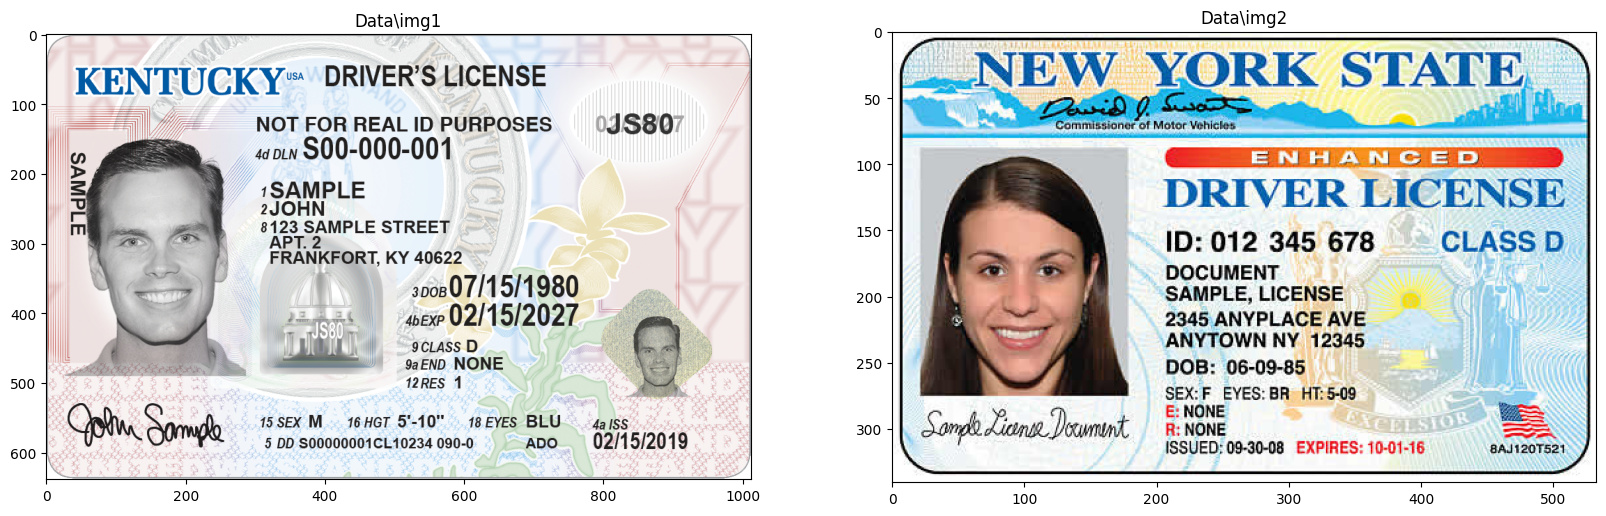

In [5]:
display_imgs(img_file_names)

# Image Preprocessing

In [6]:
def normalize_img(img):
    norm_img = np.zeros((img.shape[0], img.shape[1]))
    img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
    return img

def read_img(img):
    temp_image = cv2.imread(img)
    return temp_image

def remove_noise(image):
    img = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)
    return img

def get_grayscale(image):
    img =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return img
    
def thresholding(image):
    img = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)[1]
    return img

def binarization(image):
    ret, img = cv2.threshold(image, 0, 255,cv2.THRESH_BINARY,cv2.THRESH_OTSU)
    return img

def preprocess_image(img):
    img = read_img(img)
    img = normalize_img(img)
    img = remove_noise(img)
    img = get_grayscale(img)
    #img = thresholding(img)
    #img = binarization(img)
    return img


In [10]:
pro_img = [preprocess_image(img) for img in img_file_names]


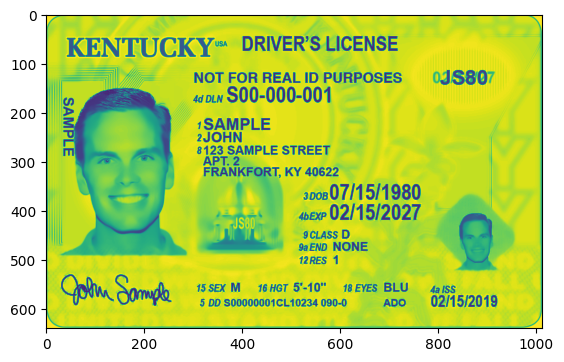

In [59]:
plt.imshow(pro_img[0])

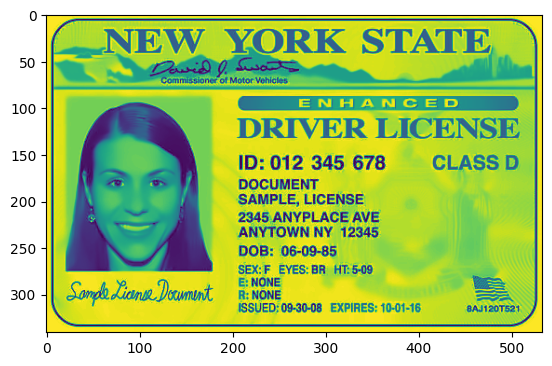

In [12]:
plt.imshow(pro_img[1])

# Method 1: pytesseract

In [13]:
def img_to_text(img):
    text = pytesseract.image_to_string(img, lang='eng')
    return text

In [27]:
text = pytesseract.image_to_string(img_file_names[0], lang='eng')
text2 = pytesseract.image_to_string(img_file_names[1], lang='eng')

In [17]:
print(pytesseract.image_to_string(img_file_names[0], lang='eng'))

| KENTUCKY DRIVER’S LICENSE

NOT FOR REAL ID PURPOSES JIS80
«ow 900-000-001

1SAMPLE /
2JOHN
tess AMELE STREET

FRANKFORT, KY 40622
300807/15/1980
aoexe 02/15/2027 >

i, S9eLass-D
9aEND NONE
12RES 1

  
 
      

15SEX M_ 16HGT 5'-10" 18 EYES BLU 4aiss
5 DD $00000001CL10234090-0 Ado ‘02/15/2019



In [60]:
print(pytesseract.image_to_string(pro_img[1], lang='eng'))

—NEW.

ORK ST

stono of Motor Veh

—ennance>
DRIVER LICENSE

ID: 012 345 678 CLASS D
DOCUMENT

SAMPLE, LICENSE

2345 ANYPLACE AVE

ANYTOWN NY 12345

DOB: 06-09-85

SEX:F EYES: BR HT:5-09

E: NONE a
R:NOI aS

AN
ISSUED: 09-80-08 EXPIRES: 10-01-16 ‘sasrz0Ts21




## Get Name

In [19]:
def parse_name_address(text):
    # Define a regex pattern to detect lines starting with numbers (address)
    address_pattern = re.compile(r'^\d+.*$', re.MULTILINE)
    
    # Split the text at the address part
    parts = address_pattern.split(text, 1)
    
    # Check if we have the expected parts
    if len(parts) > 1:
        # Extract the part before the address
        before_address = parts[0].strip()
        
        # Extract the two strings before the address
        lines = before_address.split('\n')
        two_strings_before_address = lines[-2:]  # Get the last two lines
        
        # Ensure we have exactly two lines
        if len(two_strings_before_address) == 2:
            return f"{two_strings_before_address[0]} {two_strings_before_address[1]}"
        else:
            raise ValueError("Unable to extract two strings before the address.")
    else:
        raise ValueError("Address not found in the text.")

def parse_name_identifier(text):
    # Define a regex pattern to find lines that start with digits followed by a name
    name_pattern = re.compile(r'\b\d+([A-Z]+)\s*/?\s*\n?\b\d+([A-Z]+)', re.MULTILINE | re.IGNORECASE)
    
    # Search for the pattern in the text
    match = name_pattern.search(text)
    
    # If a match is found, extract the names
    if match:
        name1 = match.group(1).strip()
        name2 = match.group(2).strip()
        return f"{name1} {name2}"
    #else:
        #raise ValueError("Names not found in the text.")

def combined_parser(text):
    # First try to parse the names associated with digits
    names = parse_name_identifier(text)
    
    # If no names were found using the first method, try using the address method
    if not names:
        names = parse_name_address(text)
    
    return names

In [30]:
names = combined_parser(text2)
names

['DOCUMENT', 'SAMPLE, LICENSE']

## Check validity

In [53]:
def check_if_valid(text):
    
    dates_str = get_dates(text)
    valid = isValid(dates_str)
    
    print(f'Expiration Date: {valid[0]}')
    
    if valid[1] == False:
        print('Warning: Expired')
    else:
        print('Accepted')
    
def parse_date(date_string):
    # List of possible date formats
    date_formats = ['%m/%d/%Y', '%m-%d-%Y', '%m/%d/%y', '%m-%d-%y'] 
    for fmt in date_formats:
        try:
            return datetime.strptime(date_string, fmt)
        except ValueError:
            continue

def get_dates(text):
    # Regular expression to find dates in MM/DD/YYYY format
    date_pattern = r'\b\d{2}[/-]\d{2}[/-]\d{2,4}\b'

    # Find all matches
    dates = re.findall(date_pattern, text)

    return dates
            
def isValid(dates_str):
    # Parse dates and filter out None values
    dates = [parse_date(date) for date in dates_str if parse_date(date) is not None]
    
    # expriation date will be the greatest date in the text
    expiration_date = max(dates)
    # Convert the greatest date back to a string if needed
    expiration_date_str = expiration_date.strftime('%m/%d/%Y')

    today = datetime.now()
    
    # Compare today's date with the greatest date to determine
    if today > expiration_date:
        #print('Warning: Expired')
        return (expiration_date_str, False)
    else:
        #print('Accepted')
        return (expiration_date_str, True)
    

In [54]:
check_if_valid(text)

Expiration Date: 02/15/2027
Accepted


In [36]:
# Parse through OCR text to determine if the lisecne is valid or not
dates_str = get_dates(text2)
valid = isValid(dates_str)


Expiration Date: 10/01/2016


## Main Methods

In [ ]:
def main(img):
    pro_img = preprocess_image(img)
    ocr_text = img_to_text(pro_img)
    
    extracted_names = combined_parser(ocr_text)
    print(f'{extracted_names}')
    is_valid = check_if_valid(ocr_text)
    
    return

In [ ]:
main(img_file_names[1])

 SAMPLE, LICENSE
Expiration Date: 10/01/2016


# Test Pypdf

In [ ]:
from pypdf import PdfReader 

In [ ]:
pdf = pytesseract.image_to_pdf_or_hocr(pro_img[0])

with open('test4.pdf','w+b') as f:
    f.write(pdf)

In [ ]:
# creating a pdf reader object 
reader = PdfReader('test4.pdf') 
  
# printing number of pages in pdf file 
print(len(reader.pages)) 
  
# getting a specific page from the pdf file 
page = reader.pages[0] 
  
# extracting text from page 
text = page.extract_text() 
print(text.split()) 

In [ ]:
# creating a pdf reader object 
reader = PdfReader('test2.pdf') 
  
# printing number of pages in pdf file 
print(len(reader.pages)) 
  
# getting a specific page from the pdf file 
page = reader.pages[0] 
  
# extracting text from page 
text = page.extract_text() 
print(text.split()) 

In [ ]:
# creating a pdf reader object 
reader = PdfReader('test2.pdf') 
  
# printing number of pages in pdf file 
print(len(reader.pages)) 
  
# getting a specific page from the pdf file 
page = reader.pages[0] 
  
# extracting text from page 
text = page.extract_text() 
print(text.split()) 

### Method 3: easyocr

In [ ]:
import easyocr

reader = easyocr.Reader(['en'], gpu = True)

In [ ]:
results = reader.readtext(img_file_names[0])
results2 = reader.readtext(img_file_names[1])

In [ ]:
pd.DataFrame(results)

In [ ]:
pd.DataFrame(results2)

In [ ]:
dfs = []
for img in img_file_names:
    result = reader.readtext(img)
    img_id = img.split('/')[-1].split('.')[0]
    img_df = pd.DataFrame(result, columns =['bbox','text','conf'])
    img_df['img_id'] = img_id
    dfs.append(img_df)
easyocr_df = pd.concat(dfs)

In [ ]:
easyocr_df

# Method 4: Mindee API

In [ ]:
!pip install mindee -q

In [ ]:
from mindee import Client, AsyncPredictResponse, product

In [ ]:
mindee_client = Client(api_key ="a0a7ea3560d931960061386986bbfbe9")

input_img = mindee_client.source_from_path(img_file_names[1])

result: AsyncPredictResponse = mindee_client.enqueue_and_parse(product.InternationalIdV2, input_img)

test2_doc = result.document

In [ ]:
final_result = str(test1_doc).split('\n')
final_result2 = str(test2_doc).split('\n')

In [ ]:
final_result

In [ ]:
final_result2